In [14]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input
from tensorflow.keras.optimizers import Adam


In [15]:
meta_df = pd.read_csv('symbols_valid_meta.csv')
print("Total Tickers:", len(meta_df))

# Show first few rows to confirm csv loads
meta_df.head()


Total Tickers: 8049


,Nasdaq Traded,Symbol,Security Name,Listing Exchange,Market Category,ETF,Round Lot Size,Test Issue,Financial Status,CQS Symbol,NASDAQ Symbol,NextShares
0,Y,A,"Agilent Technologies, Inc. Common Stock",N,,N,100.0,N,NaN,A,A,N
1,Y,AA,Alcoa Corporation Common Stock,N,,N,100.0,N,NaN,AA,AA,N
2,Y,AAAU,Perth Mint Physical Gold ETF,P,,Y,100.0,N,NaN,AAAU,AAAU,N
3,Y,AACG,ATA Creativity Global - American Depositary Sh...,Q,G,N,100.0,N,N,NaN,AACG,N
4,Y,AADR,AdvisorShares Dorsey Wright ADR ETF,P,,Y,100.0,N,NaN,AADR,AADR,N


In [16]:
# Filter Stocks
filtered = meta_df[(meta_df['ETF'] == 'N') & (meta_df['Symbol'].notnull())]
tickers = filtered['Symbol'].unique()[:1]  # You can change the number here
print("Selected ticker:", tickers[0])
ticker = tickers[0]

# Download Stock Price Data
df = yf.download(ticker, start='2020-01-01', end='2024-12-31')
df = df[['Close']]
print("Downloaded data shape:", df.shape)
print(df.head())


[*********************100%***********************]  1 of 1 completed

Selected ticker: A
Downloaded data shape: (1257, 1)
Price           Close
Ticker              A
Date                 
2020-01-02  82.885239
2020-01-03  81.554466
2020-01-06  81.795547
2020-01-07  82.046288
2020-01-08  82.856323


In [17]:
ticker = 'AAPL'
df = yf.download(ticker, start='2020-01-01', end='2024-12-31')[['Close']]
print("Data shape:", df.shape)


[*********************100%***********************]  1 of 1 completed

Data shape: (1257, 1)


In [18]:
scaler = MinMaxScaler()
df['Close'] = scaler.fit_transform(df[['Close']])

N = 5  # Number of lags
X, y = [], []
for i in range(N, len(df)):
    X.append(df['Close'].values[i-N:i])
    y.append(df['Close'].values[i])

X = np.array(X)
y = np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))  # RNN input shape


In [19]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [20]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

model = Sequential([
    Input(shape=(N, 1)),
    SimpleRNN(50, activation='tanh'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')


In [21]:
history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_split=0.1, verbose=1)


Epoch 1/30


57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0390 - val_loss: 5.7065e-04
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.5456e-04 - val_loss: 9.9265e-04
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.6261e-04 - val_loss: 5.6595e-04
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.8984e-04 - val_loss: 0.0011
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.8736e-04 - val_loss: 5.6507e-04
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.7898e-04 - val_loss: 7.5717e-04
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.5637e-04 - val_loss: 5.2404e-04
Epoch 8/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0131e-04 - val_loss: 4.2624e-04
Epoch 9/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9712e-04 - val_loss: 6.5562e-04
Epoch 10/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3308e-04 - val_loss: 3.3946e-04
Epoch 11/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.4768e-04 - val_loss: 8.8591e-04
Epoc

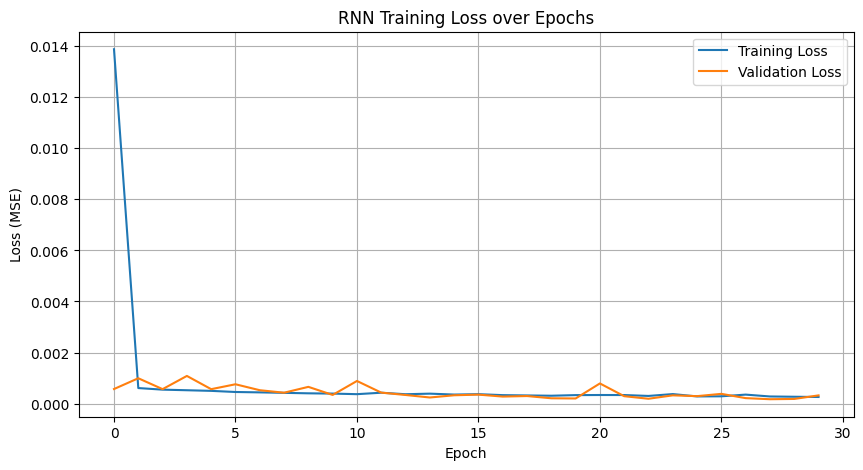

In [22]:
# Plot training & validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('RNN Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()


In [23]:
y_pred = model.predict(X_test)

y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

print("MSE:", mean_squared_error(y_test_inv, y_pred_inv))
print("R^2 Score:", r2_score(y_test_inv, y_pred_inv))


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
MSE: 35.16664934324183
R^2 Score: 0.9460821321493489


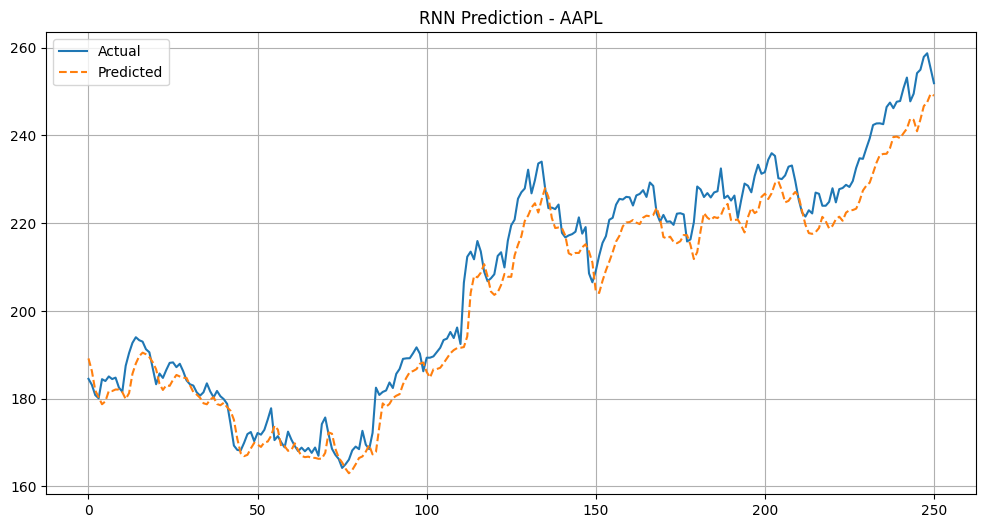

In [24]:
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted', linestyle='--')
plt.title(f'RNN Prediction - {ticker}')
plt.legend()
plt.grid(True)
plt.show()


### For The Ablation Studies

In [25]:
# Normalize 'Close' prices
scaler = MinMaxScaler()
df['Close'] = scaler.fit_transform(df[['Close']])

# Test different lookback windows
results = []

for N in [5, 10, 20]:
    # Build lagged dataset
    X, y = [], []
    for i in range(N, len(df)):
        X.append(df['Close'].values[i-N:i])
        y.append(df['Close'].values[i])
    X = np.array(X).reshape((-1, N, 1))
    y = np.array(y)

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, shuffle=False)

    model = Sequential([
        Input(shape=(N, 1)),
        SimpleRNN(50, activation='tanh'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), verbose=0)

    results.append((N, history.history['val_loss'][-1]))

# Show results
for r in results:
    print(f"Lookback N = {r[0]} --> Final Validation Loss: {r[1]:.6f}")

Lookback N = 5 --> Final Validation Loss: 0.000785
Lookback N = 10 --> Final Validation Loss: 0.000221
Lookback N = 20 --> Final Validation Loss: 0.000842


In [26]:
## Hidden Units

hidden_unit_results = []

N = 5  # Fixed lookback window
X, y = [], []
for i in range(N, len(df)):
    X.append(df['Close'].values[i-N:i])
    y.append(df['Close'].values[i])
X = np.array(X).reshape((-1, N, 1))
y = np.array(y)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, shuffle=False)

for units in [32, 50, 64, 128]:
    model = Sequential([
        Input(shape=(N, 1)),
        SimpleRNN(units, activation='tanh'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), verbose=0)

    hidden_unit_results.append((units, history.history['val_loss'][-1]))

for r in hidden_unit_results:
    print(f"Hidden Units = {r[0]} --> Final Validation Loss: {r[1]:.6f}")


Hidden Units = 32 --> Final Validation Loss: 0.000380
Hidden Units = 50 --> Final Validation Loss: 0.001293
Hidden Units = 64 --> Final Validation Loss: 0.000447
Hidden Units = 128 --> Final Validation Loss: 0.001097


In [27]:
## Learning Rate

lr_results = []

for lr in [0.01, 0.001, 0.0005]:
    model = Sequential([
        Input(shape=(N, 1)),
        SimpleRNN(50, activation='tanh'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), verbose=0)

    lr_results.append((lr, history.history['val_loss'][-1]))

for r in lr_results:
    print(f"Learning Rate = {r[0]} --> Final Validation Loss: {r[1]:.6f}")


Learning Rate = 0.01 --> Final Validation Loss: 0.000260
Learning Rate = 0.001 --> Final Validation Loss: 0.001433
Learning Rate = 0.0005 --> Final Validation Loss: 0.003246
